In [1]:
# Copyright (c) 2015-2016, the authors (see AUTHORS.txt).
# Licensed under the BSD 3-clause license (see LICENSE.txt)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import unittest
import deepgp
import GPy
import os
import h5py
import tables

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import sparse_ops

import rbf_kernel
from densities import multivariate_normal

base_path = os.path.dirname("__file__")

In [2]:
# def const(x):
#     x = tf.constant(x,dtype=tf.float32)
#     return x

# plt.subplots(2,3,figsize=(10,6))

# def build_toy_dataset(N, D, K, Ngrid = 100, prior_l=2, prior_sig_f=1, l=0.5, sig_f=1, sig_n=1e-1):
#     Nall = Ngrid + N
#     tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)

#     sess = ed.get_session()
#     with sess.as_default():
#         Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

#     z_mu = np.zeros(N)
#     z_cov = Kprior + 1e-10*np.eye(N)
#     z = np.random.multivariate_normal(z_mu, z_cov).T.reshape(-1,1)
#     zgrid = np.linspace(z.min(), z.max(), num=Ngrid).reshape(-1,1)
#     zall = np.vstack((z,zgrid))

#     plt.subplot(2,3,1)
#     plt.imshow(Kprior)
#     plt.colorbar()
#     plt.subplot(2,3,2)
#     plt.plot(z)

#     with sess.as_default():
#         Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

#     Kz = Kzall[:N,:N]
#     xall = np.random.multivariate_normal(np.zeros(Nall), Kzall, D).T
#     x = xall[:N,:]
#     xgrid = xall[N:,:]
#     noise = np.random.randn(x.shape[0],x.shape[1])
#     x = x + sig_n*noise

#     plt.subplot(2,3,4)
#     plt.imshow(Kz)
#     plt.colorbar()
#     plt.subplot(2,3,5)
#     plt.imshow(np.cov(x))
#     plt.colorbar()
#     plt.subplot(2,3,6)
#     plt.plot(xgrid[:,:5])

#     return x,xgrid,z,zgrid,tgrid,Kz,Kprior

# N = 500  # number of data points, number of time points
# D = 200  # data dimensionality, number of neurons
# K = 1  # latent dimensionality

# x_true, xgrid, z_true, zgrid, tgrid, Kz_true, Kprior_true = build_toy_dataset(N, D, K)

# print("Number of data points N={}".format(N))
# print("Number of features D={}".format(D))
# print("Number of latent dimensions K={}".format(K))

# pca = PCA(n_components=1)
# z_init = pca.fit_transform(x_true)

# # visualize the covariance of Z
# plt.subplot(2,3,3)
# plt.plot(z_init)

# scipy.io.savemat('syn.mat',mdict={'x_true':x_true, 'xgrid':xgrid, 'z_true':z_true, 'zgrid':zgrid, 
#                                   'tgrid':tgrid, 'Kz_true':Kz_true, 'Kprior_true':Kprior_true})

<IPython.core.display.Javascript object>


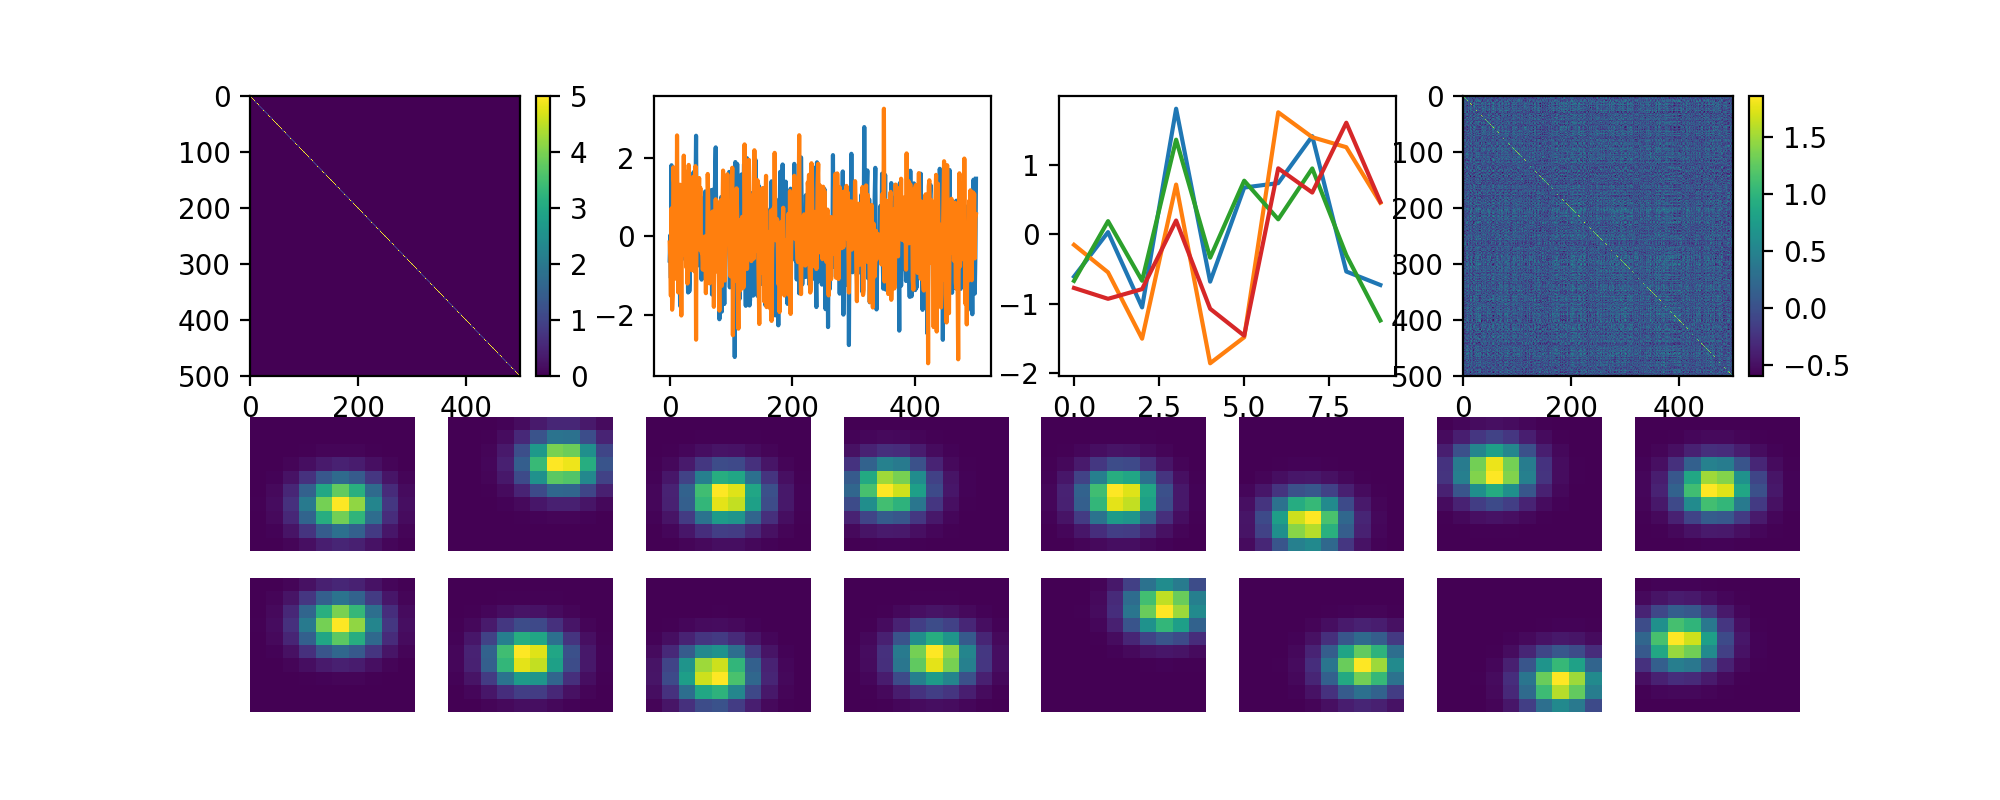

Number of data points N=500
Number of features D=100
Number of latent dimensions K=2


In [3]:
data = scipy.io.loadmat('syn2d.mat')
x_true = data['x_true']
xgrid = data['xgrid']
z_true = data['z_true']
zgrid = data['zgrid']
tgrid = data['tgrid']
Kprior_true = data['Kprior_true']

N = x_true.shape[0]
D = x_true.shape[1]
K = z_true.shape[1]
Ngrid = int(np.sqrt(xgrid.shape[0]))

pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

plt.subplots(4,8,figsize=(10,4))
plt.subplot(2,4,1)
plt.imshow(Kprior_true,aspect='auto')
plt.colorbar()
plt.subplot(2,4,2)
plt.plot(z_true)

def align_z(x,z):
    wgt = np.linalg.lstsq(x-x.mean(), z-z.mean())[0]   
    xx = np.dot(x-x.mean(),wgt)
    return xx

# visualize the covariance of Z
plt.subplot(2,4,3)
plt.plot(z_true[:10,:])
plt.plot(align_z(z_init,z_true)[:10,:])

extent = z_true[:,0].min(), z_true[:,0].max(), z_true[:,1].min(), z_true[:,1].max()
plt.subplot(2,4,4)
plt.imshow(np.cov(x_true),aspect='auto')
plt.colorbar()

ii = np.random.randint(0,D,16)

for i in range(16):
    plt.subplot(4,8,i+17)
    plt.imshow(xgrid[:,ii[i]].reshape(Ngrid,Ngrid),extent=extent,aspect='auto')
    plt.axis('off')


print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

In [7]:
# define functions to create weight and bias variables, from TensorFlow.org
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(-0.1, shape=shape)
  return tf.Variable(initial)

def const(x):
    x = tf.constant(x,dtype=tf.float32)
    return x

z = tf.Variable(z_init, dtype=tf.float32)
# z = tf.Variable(tf.ones([N, K])*1e-2, dtype=tf.float32)
x = tf.placeholder(tf.float32, shape=[N, D])

prior_sig_n = const(np.log(1))
sig_n = const(np.log(1))
# sig_f = const(np.log(1))
# l = const(np.log(1))
# sig_n = tf.Variable(np.log(0.01), dtype=tf.float32)
sig_f = tf.Variable(np.log(1), dtype=tf.float32)
l = tf.Variable(np.log(1), dtype=tf.float32)

if 1:
    Kz = rbf(z,lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n)*tf.eye(N)
else:
    M = 50
    sig_n_u = const(np.log(0.01))
    u = tf.Variable(tf.random_normal([M, K]), dtype=tf.float32)
    Ku = rbf(u,lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n_u)*tf.eye(M)
    Kzu = rbf(z,u,lengthscale=tf.exp(l),variance=tf.exp(sig_f))
    Kz = tf.matmul(Kzu,tf.matmul(tf.matrix_inverse(Ku),tf.transpose(Kzu)))+tf.exp(sig_n)*tf.eye(N)

loss = - multivariate_normal(x, 0, tf.cholesky(Kz)) + 0.5*tf.exp(prior_sig_n)*tf.trace(tf.matmul(tf.transpose(z),z))
opt = tf.train.RMSPropOptimizer(learning_rate=0.005, decay=0.95, momentum=0.1).minimize(loss)

# train network
epochs = 5000
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
fd = {x:x_true}
for epoch in range(epochs) :
    opt.run(feed_dict=fd)
    current_loss,sig_f_est,sig_n_est,l_est = sess.run([loss,sig_f,sig_n,l],feed_dict=fd) 
    if epoch % 100 == 0:
        print("Epoch:", '%04d' % (epoch+1), "loss=", "{:.9f}".format(current_loss)
             , "sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
             , "l_est=", "{:.9f}".format(np.exp(l_est)))


Epoch: 0001 loss= 80587.773437500 sig_f_est= 0.977887511 sig_n_est= 1.000000000 l_est= 1.022612572
Epoch: 0101 loss= 76896.460937500 sig_f_est= 0.575764954 sig_n_est= 1.000000000 l_est= 1.812262654
Epoch: 0201 loss= 75215.656250000 sig_f_est= 0.423598737 sig_n_est= 1.000000000 l_est= 2.843646765
Epoch: 0301 loss= 74335.867187500 sig_f_est= 0.528634012 sig_n_est= 1.000000000 l_est= 3.077946663
Epoch: 0401 loss= 73652.757812500 sig_f_est= 0.477055818 sig_n_est= 1.000000000 l_est= 2.273123026
Epoch: 0501 loss= 73101.351562500 sig_f_est= 0.459383994 sig_n_est= 1.000000000 l_est= 1.785199285
Epoch: 0601 loss= 72679.695312500 sig_f_est= 0.455013514 sig_n_est= 1.000000000 l_est= 1.425697207
Epoch: 0701 loss= 72366.492187500 sig_f_est= 0.450716674 sig_n_est= 1.000000000 l_est= 1.180589080
Epoch: 0801 loss= 72103.593750000 sig_f_est= 0.453871250 sig_n_est= 1.000000000 l_est= 1.066612244
Epoch: 0901 loss= 71879.085937500 sig_f_est= 0.462850720 sig_n_est= 1.000000000 l_est= 0.830102265
Epoch: 100

sig_f_est= 0.452573508 sig_n_est= 1.000000000 l_est= 0.143284023


<IPython.core.display.Javascript object>


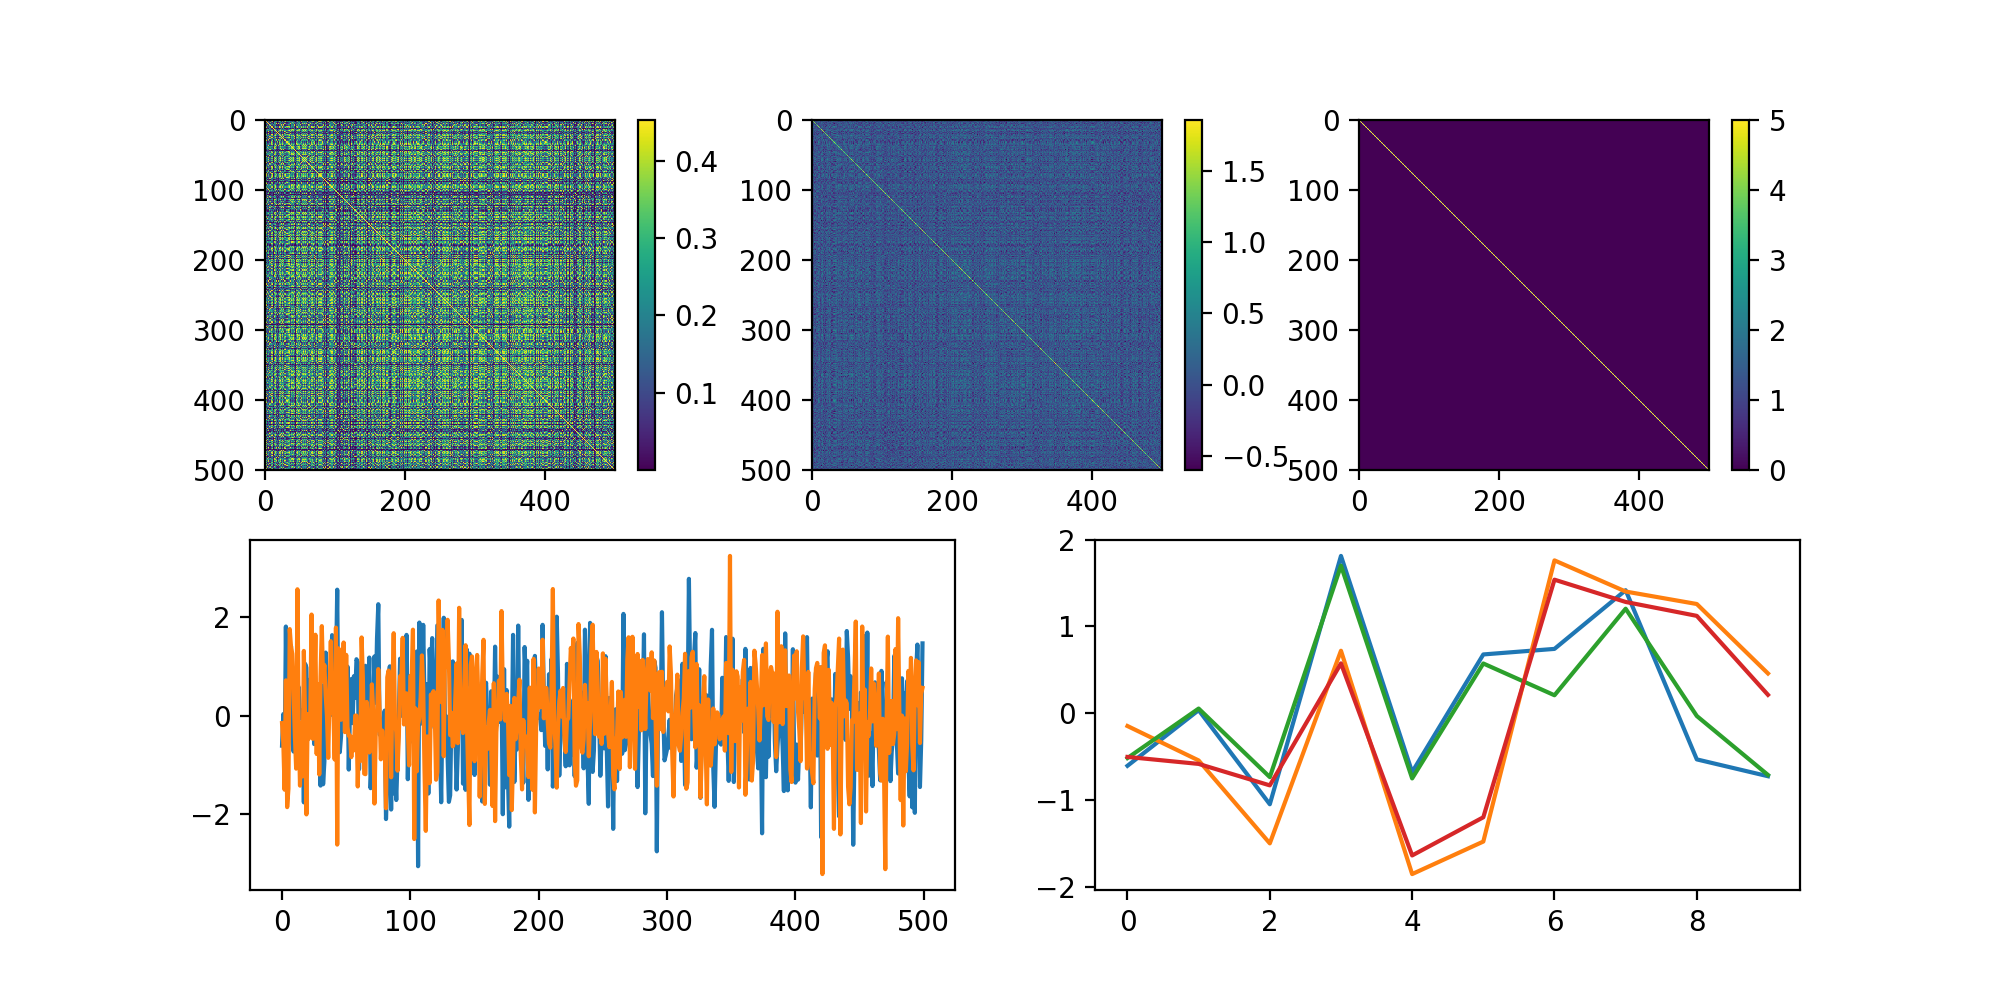

In [8]:
z_est, sig_f_est, sig_n_est, l_est = sess.run([z,sig_f,sig_n,l],feed_dict=fd)
print("sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
      , "l_est=", "{:.9f}".format(np.exp(l_est)))

Kz = rbf(const(z_est),lengthscale=tf.exp(l_est),variance=tf.exp(sig_f_est)).eval()

plt.subplots(2,3,figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(Kz)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,2,3)
plt.plot(z_true)
plt.subplot(2,2,4)
plt.plot(align_z(z_true,z_true)[:10,:])
plt.plot(align_z(z_est,z_true)[:10,:])


[ 5 89 19 24 73 70 80 28]


<IPython.core.display.Javascript object>


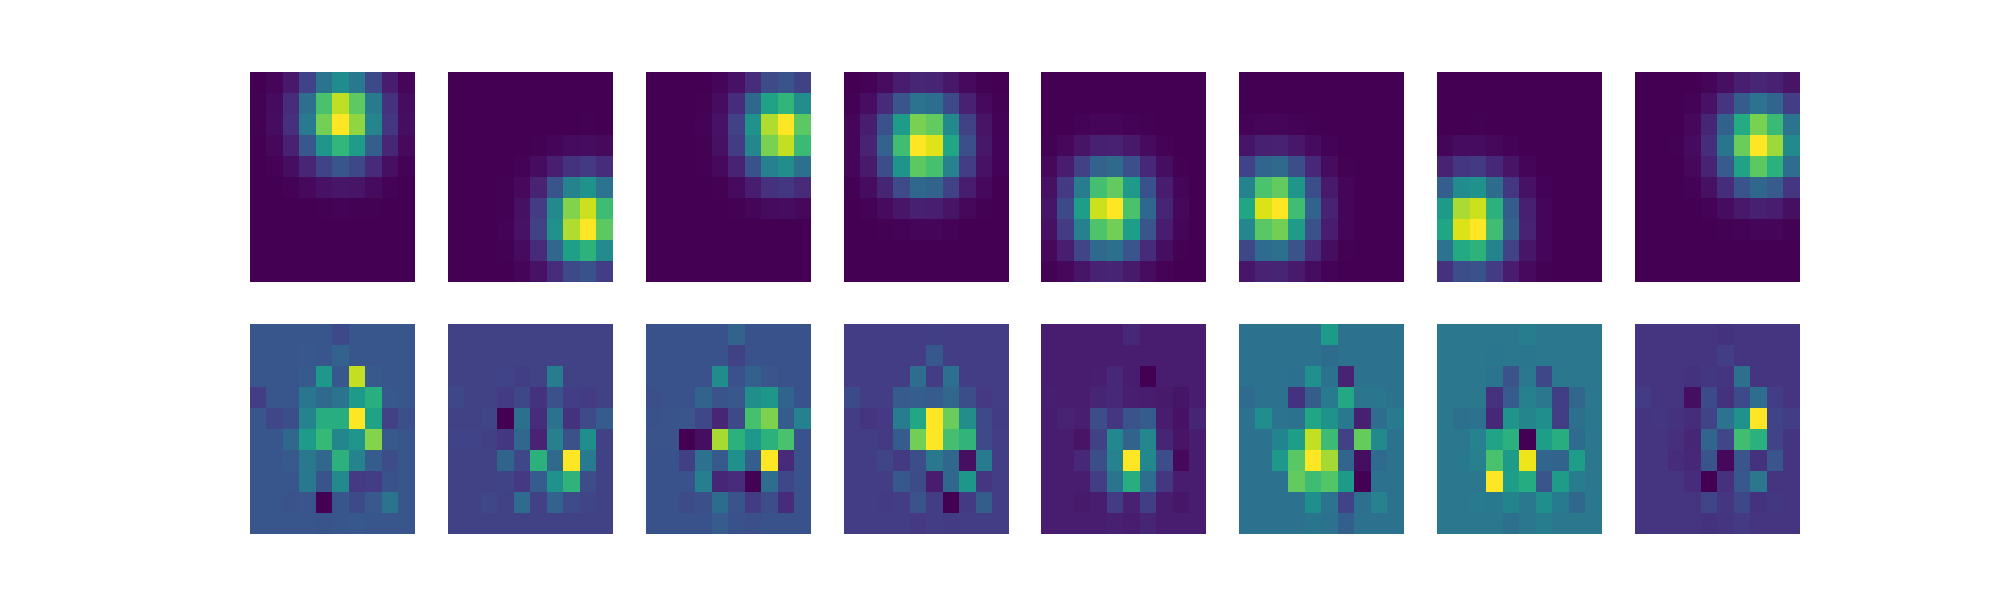

In [9]:
z_est1 = align_z(z_est,z_true)
Kxx = rbf(const(z_est1),lengthscale=tf.exp(l_est),variance=tf.exp(sig_f_est)).eval()
Kxx_noise = Kxx + np.exp(sig_n_est)*np.eye(N)
Ky = Kxx @ x_true
invKxx = np.linalg.inv(Kxx_noise)
f_tc = invKxx @ Ky

zgridx,zgridy = np.meshgrid(np.linspace(z_est1[:,0].min(), z_est1[:,0].max(), num=Ngrid), 
                            np.linspace(z_est1[:,1].min(), z_est1[:,1].max(), num=Ngrid))
zgrid_est = np.vstack((zgridx.reshape(1,-1),zgridy.reshape(1,-1))).T
Kgx = rbf(const(zgrid_est),const(z_est1),lengthscale=tf.exp(l_est),variance=tf.exp(sig_f_est)).eval()
xgrid_est = Kgx @ invKxx @ f_tc

extent = z_true[:,0].min(), z_true[:,0].max(), z_true[:,1].min(), z_true[:,1].max()
extent_est = z_est1[:,0].min(), z_est1[:,0].max(), z_est1[:,1].min(), z_est1[:,1].max()

ii = np.random.randint(0,D,8)
print(ii)

plt.subplots(2,8,figsize=(10,3))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(xgrid[:,ii[i]].reshape(Ngrid,Ngrid),extent=extent,aspect='auto')
    plt.axis('off')
    plt.subplot(2,8,i+9)
    plt.imshow(xgrid_est[:,ii[i]].reshape(Ngrid,Ngrid),extent=extent_est,aspect='auto')
    plt.axis('off')    